# How little data do we need to fit a sine wave?


So really how little data do we need to fit a sine wave? Or alternatively how does our frequency determination improve with various forms of extra data.

The dimension we will explore are:
1. Sampling rate (in number of samples per period)
2. Sampling length (in number of periods sampled)
3. Signal-noise-ratio (SNR) -- (which we can either measure in linear or log world) 

To make things simple we will assume we are above the Nyquist sampling rate.

### Linear SNR (e.g. voltage SNR)
The simplest definition of SNR in the linear regime is the amplitude of the signal (e.g. peak-to-peak over 2) divided by the sigma of the noise (asssuming a normal/Gaussian noise distribution).

So SNR,
$$ \textrm{SNR} = \frac{\frac{P2P}{2}}{\sigma}= \frac{A}{\sigma} $$
where $A$ is the amplitude of the signal

### Power SNR 
Or we can define SNR in terms of power (normally in temrs number of decibels the signal is above noise).

We can define the noise power and the signal power as mean squared value
$$ 
P = \frac{1}{N} \sum_{i=0}^{N-1} (y_i)^2 $$
where $y_i$ are the individual samples of pure noise or signal. We will model the noise using a normal distribution with a mean of 0 and width of $\sigma$ so $P_{noise}=\sigma^2$ 


Meanwhile for a sine wave defined as $y = A \sin (wt + \phi)$ the power in the signal (averaged over a whole number of periods) is $P_{signal}=\frac{A^2}{2}$

So the power SNR is
$$ \textrm{SNR}_P = \frac{A^2}{2 \sigma^2}$$

To get the SNR in decibels we use
$$ SNR_{dB} = 10 \log_{10} \left(\frac{P_{signal}}{P_{noise}} \right) = 10 \log_{10} \left( \frac{A^2}{2 \sigma^2} \right) $$


## Conclusions -- What did we learn?

The fractional error on the frequency is described remarkably well by a very simple formula:
$$ \frac{\Delta f}{f} = \frac{\sigma} {\sqrt{2 N_{samples} N_{period}^3}}  = \frac{1}{\textrm{SNR} * \sqrt{2 N_{samples} N_{period}^3}} $$
where $\sigma$ is the noise sigma for a signal amplitude of 1 (so $\sigma$ is the inverse of linear SNR), $N_{samples}=\frac{R}{f}$ where $R$ is the sampling rate (number of samples per second) and $\frac{R}{f}$ is the number of samples per period and $N_{period}$ is the number of periods. 

Or altenative as a variance on $f$
$$ (\Delta f)^2 = \frac{f^2}{(\textrm{SNR})^2 2 N_{samples} N_{period}^3} $$
or 
$$ (\Delta f)^2 = \frac{f^3 \sigma^2}{A^2 2 R N_{period}^3} $$
or
$$ (\Delta f)^2 = \frac{f^3 \sigma^2}{A^2 2 R \left( f T \right)^3 }= \frac{\sigma^2}{A^2 2 R T^3 } =  \frac{1}{4 \textrm{SNR}_{P}  R T^3 }$$
where $R$ is the sampling rate, $T$ is the total measurement time and $\textrm{SNR}_{P}= \frac{A^2}{2 \sigma^2}$.

For this study we have limited ourselves to relatively large values of $\frac{R}{f} \geq 10$ since we are interested in the estimating frequency from the shortest time spans (i.e. low number of periods.)

In [1]:
# Import some standard python analysis and plotting packages
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

In [3]:
#Now let's get some numbers between 0 and 1
t=np.linspace(0,1,100)

# Then if we set the angular frequency to  2pi we will have 1 full period before 0 and 1
yclean=getSine(t,2*math.pi,1,0)


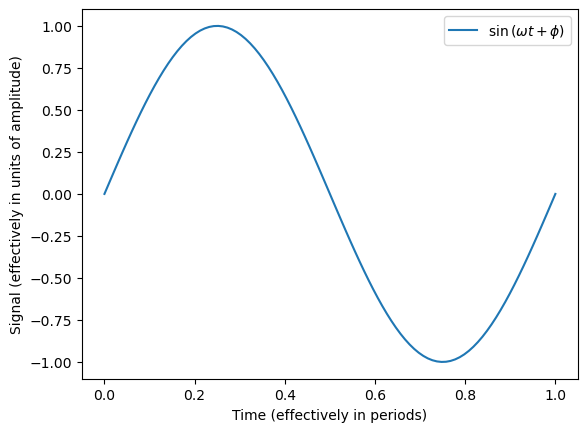

In [4]:
#Now let's plot our sine wave
fig,ax = plt.subplots()
ax.plot(t,getSine(t,2*math.pi,1,0),label=r"$\sin \left( \omega t + \phi \right)$")
ax.set_xlabel("Time (effectively in periods)")
ax.set_ylabel("Signal (effectively in units of amplitude)")
ax.legend()

## Curve fitting
Now we are going to try and do some curve fitting to this 1 period piece of data and see how well we can determine the frequency

We will do this test using the curve_fit function from scipy's optimize library

With infinte SNR how well can we determine the frequency of a sine wave using a single period of data??

In [5]:
# Import the curve_fit function
from scipy.optimize import curve_fit

# Actually do the fit to the clean data
parameters, covariance = curve_fit(getSine, t, yclean)

In [6]:
print("parameters",parameters)
print("covariance",covariance)
print("frequency error",1-(parameters[0]/(2*math.pi)))
print("error on frequency from fit",np.sqrt(covariance[0][0]))


parameters [ 6.28318531e+00  1.00000000e+00 -6.07755287e-09]
covariance [[ 4.61446704e-19  3.48221400e-20 -5.15581738e-20]
 [ 3.48221400e-20  1.13309837e-19 -3.44021867e-21]
 [-5.15581738e-20 -3.44021867e-21  1.83208630e-20]]
frequency error -1.215479272786979e-09
error on frequency from fit 6.792986857683686e-10


## Noiseless -- 5 parts in 10^10

So at infinite SNR we can determine the frequency to better than 5 parts in $10^10$ using just a single period of data

In [7]:
parameters, covariance = curve_fit(getSine, t, yclean+np.random.normal(0,1e-9,size=yclean.size))

In [8]:
print(parameters)

[6.28318529e+00 9.99999999e-01 1.11108751e-08]


In [33]:
noise=np.random.normal(0,1,size=yclean.size)
print("Mean squared power in sine wave:",np.mean(yclean**2))
print("Mean squared power in noise:",np.mean(noise**2))

def getSNRdB(signal,noise):
    Ps=np.mean(signal**2)
    Pn=np.mean(noise**2)
    return 10*math.log10(Ps/Pn)

def getFractionalError(sigma,numPeriods,sampsPerPeriod):
    return sigma / np.sqrt(2*sampsPerPeriod * numPeriods**3)


def getAbsoluteFrequencyVariance(snrp,samplingRate,observationTime):
    return 1.2 / (4*snrp*samplingRate*observationTime**3)  #No idea where the 1.2 comes from

def getOmegaVariance(snrp,samplingRate,observationTime):
    return 12 / (snrp*(samplingRate*observationTime**3 - observationTime/samplingRate))

def getFracVariance(snrp,numPeriods,sampsPerPeriod):
    return 1.2/ (4 *snrp*sampsPerPeriod*numPeriods**3)

print("SNR in dB:",getSNRdB(yclean,noise))
print("SNR in dB:",getSNRdB(yclean,np.random.normal(0,0.05,size=yclean.size)))


Mean squared power in sine wave: 0.495
Mean squared power in noise: 0.9515963793788857
SNR in dB: -2.8384758203699576
SNR in dB: 23.5296980327988


In [10]:
#numThrows=1000
#numSamplesPerPeriod=100 
trueFreq=1
trueOmega=trueFreq*2*math.pi
trueAmp=1
truePhase=0


def doMonteCarloPoint(numThrows,numSamplesPerPeriod,noiseSigma,numPeriods):

    snrs=np.zeros(numThrows)
    omegas=np.zeros(numThrows)
    freqs=np.zeros(numThrows)
    amps=np.zeros(numThrows)
    phases=np.zeros(numThrows)


    t=np.linspace(0,numPeriods,numPeriods*numSamplesPerPeriod)
    signal=getSine(t,trueOmega,trueAmp,truePhase)

    #noiseSigma=0.1

    failCount=0
    for i in range(numThrows):
        noise=np.random.normal(0,noiseSigma,size=signal.size)
        snrs[i]=getSNRdB(signal,noise)
        try:
            parameters, covariance = curve_fit(getSine, t, signal+noise,p0=[trueOmega,trueAmp,truePhase])
        except:
            print("Failure ",failCount," to fit",numSamplesPerPeriod,noiseSigma,numPeriods,i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    
    return snrs,omegas,amps,phases,freqs
    

omega std 0.045904001779783155
freq std 0.00730584879095165
16.970816982426125


(array([ 10.,  29.,  89., 156., 193., 203., 166.,  99.,  37.,  18.]),
 array([0.9797262 , 0.9837456 , 0.98776501, 0.99178442, 0.99580383,
        0.99982323, 1.00384264, 1.00786205, 1.01188146, 1.01590086,
        1.01992027]),
 <BarContainer object of 10 artists>)

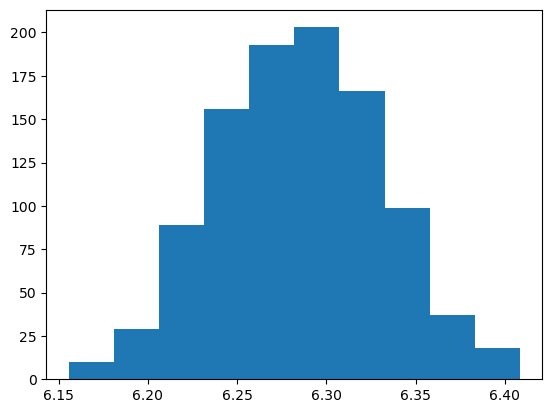

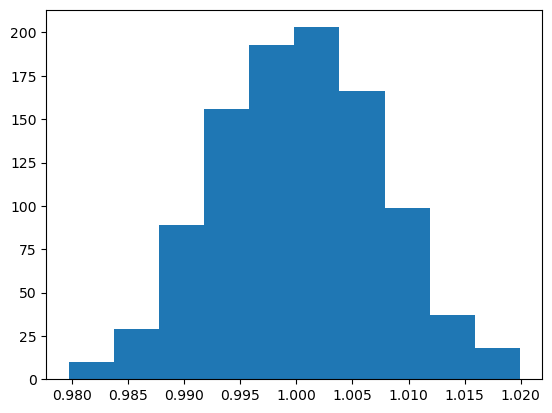

In [11]:
snrs,omegas,amps,phases,freqs=doMonteCarloPoint(1000,100,0.1,1)
fig,ax = plt.subplots()
ax.hist(omegas)
print("omega std",np.std(omegas))
print("freq std",np.std(freqs))
print(np.mean(snrs))
fig,ax = plt.subplots()
ax.hist(freqs)

In [12]:
def getOmegaSnr(numThrows,numSampsArray,noise,numPeriods):
    omegaStd=[]
    snrMean=[]
    for val in numSampsArray:
        numSamps=int(val)
        snrs,omegas,amps,phases,freqs=doMonteCarloPoint(numThrows,numSamps,noise,numPeriods)
        omegaStd.append(np.std(omegas))
        snrMean.append(np.mean(snrs))
    omegaStd=np.array(omegaStd)
    snrMean=np.array(snrMean)
    return omegaStd,snrMean

def getFreqSnr(numThrows,numSampsArray,noise,numPeriods):
    freqStd=[]
    snrMean=[]
    for val in numSampsArray:
        numSamps=int(val)
        snrs,omegas,amps,phases,freqs=doMonteCarloPoint(numThrows,numSamps,noise,numPeriods)
        freqStd.append(np.std(freqs))
        snrMean.append(np.mean(snrs))
    freqStd=np.array(freqStd)
    snrMean=np.array(snrMean)
    return freqStd,snrMean

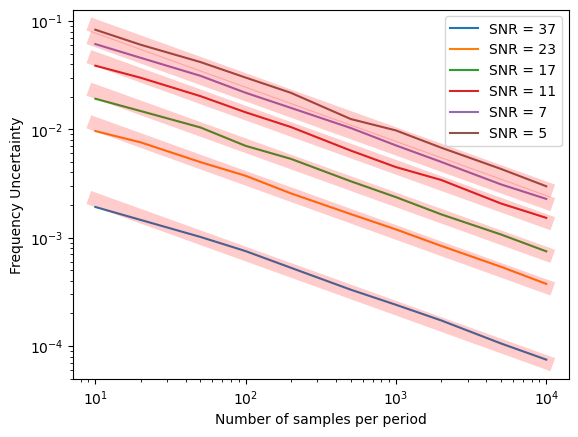

In [13]:
fig,ax = plt.subplots()
numSampsArray=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
noiseArray=np.array([0.01,0.05,0.1,0.2,0.3,0.4])
freqSnrArray=[]
snrMeanArray=[]
for noise in noiseArray:
    freqStd,snrMean=getFreqSnr(1000,numSampsArray,noise,1)
    freqSnrArray.append(freqStd)
    snrMeanArray.append(snrMean)
    ax.plot(numSampsArray,freqStd/trueFreq,label="SNR = "+str(round(np.mean(snrMean))))
    ax.plot(numSampsArray,getFractionalError(noise,1,numSampsArray),lw=10,alpha=0.2,color='red')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()
freqSnrArray=np.array(freqSnrArray)
snrMeanArray=np.array(snrMeanArray)

(6, 10)
(6, 10)
[36.99386352 22.99827187 16.98492965 10.96332629  7.44969189  4.94320813]
[0.00066016 0.00331233 0.00659237 0.01317471 0.02037928 0.02737157]


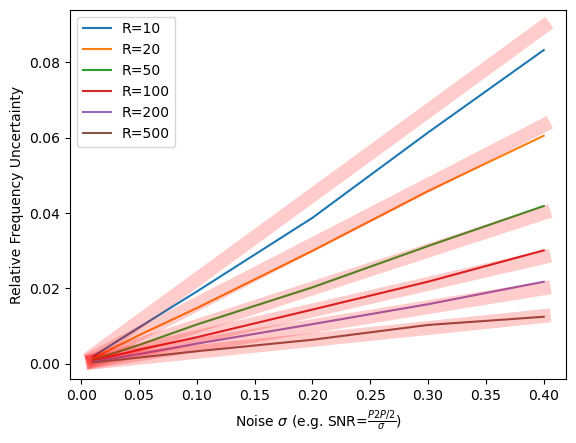

In [14]:
print(np.shape(snrMeanArray))
print(np.shape(freqSnrArray))
print(np.mean(snrMeanArray,axis=1))
print(np.mean(freqSnrArray,axis=1))
fig,ax = plt.subplots()
for i in range(np.shape(freqSnrArray)[0]):
    ax.plot(noiseArray,freqSnrArray.T[i]/trueFreq,label="R="+str(numSampsArray[i]))
    ax.plot(noiseArray,getFractionalError(noiseArray,1,numSampsArray[i]),lw=10,alpha=0.2,color='red')
    
#ax.plot(noiseArray,noiseArray/noiseArray[-1],lw=10,alpha=0.2,color='red',label="y=m x")
ax.set_xlabel(r"Noise $\sigma$ (e.g. SNR=$\frac{P2P/2}{\sigma}$)")
ax.set_ylabel("Relative Frequency Uncertainty")
ax.legend()

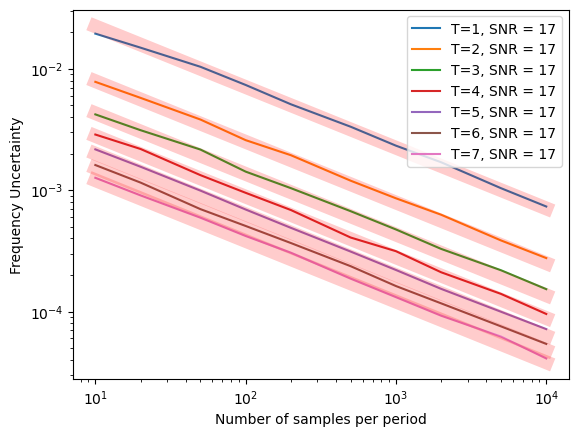

In [15]:
fig,ax = plt.subplots()
noise=0.1

freqArray=[]

for period in range(1,8):
    freqStd,snrMean=getFreqSnr(1000,numSampsArray,noise,period)
    freqArray.append(freqStd/trueFreq)
    ax.plot(numSampsArray,freqStd/trueFreq,label="T="+str(period)+", SNR = "+str(round(np.mean(snrMean))))
    ax.plot(numSampsArray,getFractionalError(noise,period,numSampsArray),lw=10,alpha=0.2,color='red')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()

In [16]:
freqArray=np.array(freqArray)
print(np.shape(freqArray))


(7, 10)


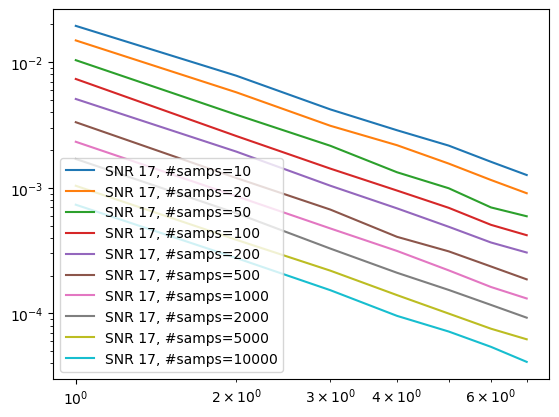

In [17]:
fig,ax = plt.subplots()
for i in range(10):
    ax.plot(range(1,8),freqArray.T[i],label="SNR 17, #samps="+str(int(numSampsArray[i])))
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

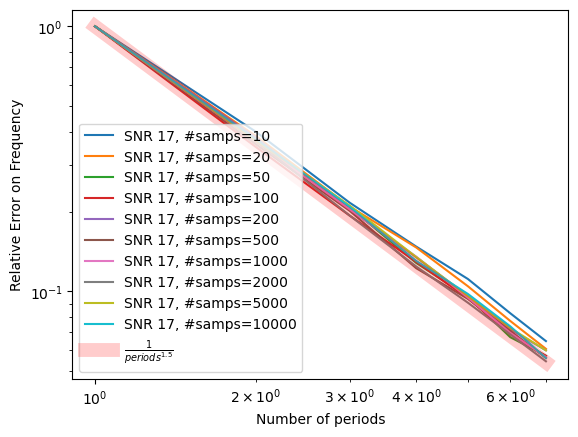

In [18]:
fig,ax = plt.subplots()
numbers=range(1,8)
for i in range(10):
    ax.plot(numbers,freqArray.T[i]/freqArray.T[i][0],label="SNR 17, #samps="+str(int(numSampsArray[i])))
ax.plot(numbers,np.power(numbers,-1.5),lw=10,alpha=0.2,color='red',label=r"$\frac{1}{periods^{1.5}}$")
ax.legend()
ax.set_xlabel("Number of periods")
ax.set_ylabel("Relative Error on Frequency")
ax.set_yscale('log')
ax.set_xscale('log')

In [19]:
print(1./np.mean(freqArray/freqArray[0,:],axis=1))
print(np.mean(freqArray/freqArray[0,:],axis=1))

[ 1.          2.68012706  4.88104945  7.50532634 10.26455495 13.80342142
 17.15974842]
[1.         0.37311664 0.20487397 0.13323871 0.09742264 0.07244581
 0.05827591]


In [20]:
numbers=np.arange(1,8)
print(numbers)

[1 2 3 4 5 6 7]


In [21]:
print(np.mean(freqArray/freqArray[0,:],axis=1)*((numbers)**1.5))

[1.         1.05533322 1.0645564  1.06590968 1.08921818 1.06473156
 1.07928501]


In [22]:
print(np.log(np.mean(freqArray/freqArray[0,:],axis=1))/np.log(numbers))

[        nan -1.4223014  -1.44305709 -1.4539574  -1.44690061 -1.46499379
 -1.46079018]


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_4930/1823280102.py:1: RuntimeWarning: invalid value encountered in divide
  print(np.log(np.mean(freqArray/freqArray[0,:],axis=1))/np.log(numbers))


In [23]:
print(1/((numbers)**1.5))

[1.         0.35355339 0.19245009 0.125      0.08944272 0.06804138
 0.05399492]


(7, 10)


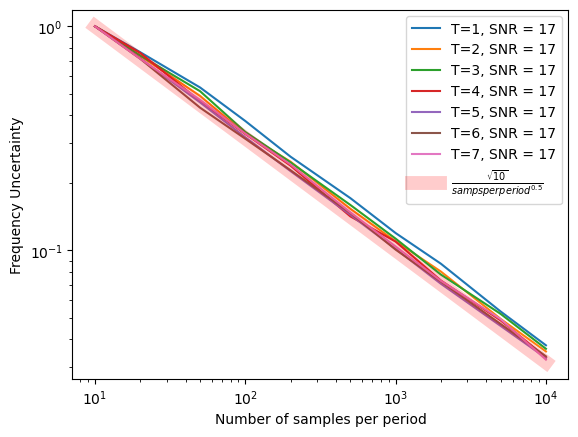

In [24]:
fig,ax = plt.subplots()
print(np.shape(freqArray))
for i in range(1,8):
    ax.plot(numSampsArray,freqArray[i-1]/freqArray[i-1][0],label="T="+str(i)+", SNR = "+str(round(np.mean(snrMean))))
ax.plot(numSampsArray,math.sqrt(10)*np.power(numSampsArray,-0.5),lw=10,alpha=0.2,color='red',label=r"$\frac{\sqrt{10}}{samps per period^{0.5}}$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()

In [25]:
freqArray=np.array(freqArray)
flipScalefreqArray=np.transpose(freqArray.T/freqArray.T[0,:])
print(flipScalefreqArray)
print(1./np.mean(flipScalefreqArray,axis=0))
print(np.mean(flipScalefreqArray[1:],axis=0))
print(np.log(np.mean(flipScalefreqArray[1:],axis=0))/np.log(numSampsArray/numSampsArray[0]))

[[1.         0.76610787 0.53330869 0.37775783 0.26177688 0.17097763
  0.11942278 0.0871485  0.05330619 0.0376719 ]
 [1.         0.73779101 0.48936671 0.33094424 0.24871195 0.15331213
  0.10982302 0.08039559 0.04937914 0.03535887]
 [1.         0.74076138 0.51325782 0.33768023 0.24678204 0.15937046
  0.11273896 0.07793733 0.05200351 0.03634528]
 [1.         0.76016469 0.46290647 0.33101358 0.23881828 0.14171265
  0.10941006 0.07332232 0.04866528 0.03326707]
 [1.         0.71920314 0.457492   0.31959958 0.22575735 0.1438659
  0.10151051 0.07092203 0.04596843 0.03307924]
 [1.         0.71647018 0.43324741 0.31485453 0.22775936 0.14672554
  0.10072882 0.07252102 0.04687816 0.03361945]
 [1.         0.71627366 0.4694786  0.33177425 0.24149712 0.14764283
  0.10400133 0.07312316 0.04920274 0.03251975]]
[ 1.          1.35743835  2.08391776  2.98682694  4.13931032  6.58137744
  9.23927167 13.07507057 20.26615558 28.94217553]
[1.         0.73177735 0.47095817 0.3276444  0.23822102 0.14877158
 0.10

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_4930/1727239744.py:6: RuntimeWarning: invalid value encountered in divide
  print(np.log(np.mean(flipScalefreqArray[1:],axis=0))/np.log(numSampsArray/numSampsArray[0]))


In [26]:
def getVariance(numThrows,R,T,SNRp,f):
    t=np.linspace(0,T,int(T*R))
    #print(t.shape)
    trueAmp=1
    truePhase=0 # Should make random or a parameter at some point
    trueOmega=2*math.pi*f
    signal=getSine(t,trueOmega,trueAmp,truePhase)
    noiseSigma=np.sqrt(trueAmp**2/(2*SNRp))
    freqs=np.zeros(numThrows)
    failCount=0
    Ps=np.mean(signal**2)
    #print("Ps",Ps)
    for i in range(numThrows):
        noise=np.random.normal(0,noiseSigma,size=signal.size)
        #if i <1:
        #    Pn=np.mean(noise**2)
        #    print("Pn",Pn)
        #    print("SNRp",SNRp,Ps/Pn)
        try:
            parameters, covariance = curve_fit(getSine, t, signal+noise,p0=[trueOmega,trueAmp,truePhase])
        except:
            print("Failure ",failCount," to fit",R,T,SNRp,i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        freqs[i]=parameters[0]/(2*math.pi)
    return freqs

In [37]:
snrp=20
f=1
T=2
R=5

rArray=np.linspace(100,4000,31)
measVarArray=[]
calcVarArray=[]
calcVarArray2=[]

for R in rArray:
    sigma=np.sqrt(1/(2*snrp))
    numPeriods=T*f
    sampsPerPeriod=R/f
    freqs=getVariance(1000,R,T,snrp,f)
    measVarArray.append(np.var(freqs))
    calcVarArray.append(getAbsoluteFrequencyVariance(snrp,R,T))
    calcVarArray2.append(getOmegaVariance(snrp,R,T)/(4*math.pi*math.pi))
   
    
    print(R,np.var(freqs),getAbsoluteFrequencyVariance(snrp,R,T),getOmegaVariance(snrp,R,T)/(4*math.pi*math.pi))

100.0 1.7921473943699915e-05 1.875e-05 1.8998196887860528e-05
230.0 7.739359974336118e-06 8.152173913043478e-06 8.259918136807482e-06
360.0 5.087049800395913e-06 5.208333333333333e-06 5.277155161069215e-06
490.0 3.8747803783051e-06 3.826530612244898e-06 3.87709014571643e-06
620.0 2.8842184077294697e-06 3.0241935483870967e-06 3.0641506916749474e-06
750.0 2.5205068736896213e-06 2.4999999999999998e-06 2.533030716849874e-06
880.0 2.116027590966391e-06 2.1306818181818183e-06 2.158832734771122e-06
1010.0 1.787200603520824e-06 1.8564356435643564e-06 1.8809630285928134e-06
1140.0 1.5329518513290892e-06 1.644736842105263e-06 1.666467156795752e-06
1270.0 1.3593382152691027e-06 1.4763779527559054e-06 1.4958838486292582e-06
1400.0 1.3191747438848834e-06 1.3392857142857143e-06 1.356980311151247e-06
1530.0 1.197957635667636e-06 1.2254901960784314e-06 1.241681304694729e-06
1660.0 1.1278866164192792e-06 1.1295180722891566e-06 1.1444411841261646e-06
1790.0 1.0918006103125316e-06 1.047486033519553e-06 1

0.9842746005750305
0.9714390033456981


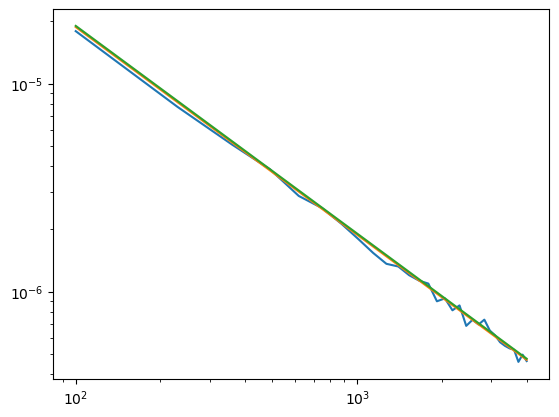

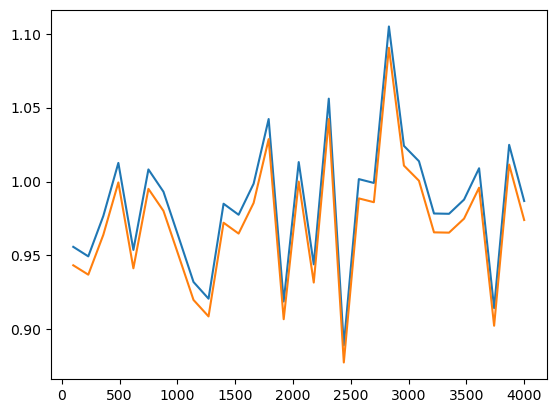

In [38]:
measVarArray=np.array(measVarArray)
calcVarArray=np.array(calcVarArray)
calcVarArray2=np.array(calcVarArray2)


fig,ax = plt.subplots()
ax.plot(rArray,measVarArray)
ax.plot(rArray,calcVarArray)
ax.plot(rArray,calcVarArray2)
ax.set_yscale('log')
ax.set_xscale('log')

fig,ax = plt.subplots()
ax.plot(rArray,measVarArray/calcVarArray)
ax.plot(rArray,measVarArray/calcVarArray2)
print(np.mean(measVarArray/calcVarArray))
print(np.mean(measVarArray/calcVarArray2))

In [29]:
np.sqrt(1.2)

1.0954451150103321

In [30]:
1.2/4

0.3

In [32]:
12/ (4*math.pi*math.pi)

0.3039635509270133